In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

A gaussian kernel is used in weighting the intensities of pixels in a particular window by giving a higher weightage to pixels near the centre of the window.

In [15]:
from scipy import signal

# Returns a weighted matrix of given dimension which acts as gaussian kernel
def get_gaussian_kernel(dim=5, sigma=1):
    get_gaussian_kernel1d = signal.gaussian(dim, std=sigma).reshape(dim, 1)
    return np.outer(get_gaussian_kernel1d, get_gaussian_kernel1d)

In [16]:
# Detects corners of a given image based on a threshold score (scores which lie in highest 2% by default)
def shi_thomasi_detector(color_image, window_size, threshold_factor=0.998):
    image = cv.cvtColor(color_image, cv.COLOR_RGB2GRAY).astype(float) / 255
    h, w = image.shape
    d = window_size // 2
    # Intensity gradients - partial derivatives along X and y axes
    Ix, Iy = np.gradient(image)
    Ix_Ix = Ix ** 2
    Iy_Iy = Iy ** 2
    Ix_Iy = Ix * Iy
    all_pixels_and_scores = []
    for i in range(d, h - d):
        for j in range(d, w - d):
            sum_xx = Ix_Ix[i - d: i + d + 1, j - d: j + d + 1].sum()
            sum_yy = Iy_Iy[i - d: i + d + 1, j - d: j + d + 1].sum()
            sum_xy = Ix_Iy[i - d: i + d + 1, j - d: j + d + 1].sum()
            # The A matrix for a fixed window around the pixel
            eigen_values, eigen_vectors = np.linalg.eig([[sum_xx, sum_xy], [sum_xy, sum_yy]])
            R = min(eigen_values)
            all_pixels_and_scores.append(tuple([R, i, j]))
    all_pixels_and_scores = sorted(all_pixels_and_scores)
    # Considering pixels with high scores as corners
    corners = all_pixels_and_scores[int(threshold_factor * len(all_pixels_and_scores)):]
    return corners

**Lucas Kanade Optical Flow**

After converting the image to grayscale and mapping pixel intensities to a value between 0 and 1, gradients along X and Y axes are computed. These are used to compute the necessary intensity matrices which are components of the matrix formulation of Lucas Kanade equation. A window around the required pixel is considered, and the above intensity matrix terms are computed for each pixel in the window and summed up, to compute motion vector for the central pixel, by solving the equation obtained via brightness constancy and spatial coherence assumption. Based on parameters passed to the function, the local structure-tensor is used to validate if a pixel's optical flow should be computed; by defining a threshold and considering those pixels whose tensor's smallest eigen value is greated than this threshold (to obtain reliable results). 

In [17]:
def LukasKanadeForwardAdditive(Img1, Img2, windowSize, T=0.01, is_weighted=False):
    image_1 = cv.cvtColor(Img1, cv.COLOR_RGB2GRAY).astype(float) / 255
    image_2 = cv.cvtColor(Img2, cv.COLOR_RGB2GRAY).astype(float) / 255
    dw, dh = windowSize[0] // 2, windowSize[1] // 2
    h, w = image_1.shape # Assumed that both images have same shapes
    # Intensity gradients - partial derivatives along X and y axes
    Ix, Iy = np.gradient(image_1)
    Ix_Ix, Ix_Iy, Iy_Iy = Ix ** 2, Ix * Iy, Iy ** 2
    # Intensity derivative with respect to time: Difference in intensities of 2 frames
    It = image_2 - image_1
    Ix_It, Iy_It =  Ix * It, Iy * It
    u, v, motion_vectors = np.zeros((h, w)), np.zeros((h, w)), {}
    weights = np.ones((windowSize[1], windowSize[0]))
    if is_weighted:
        # Assumed that a square kernel of dimension = width of window is considered
        weights = get_gaussian_kernel(dim=windowSize[0])
    for i in range(dh, h - dh):
        for j in range(dw, w - dw):
            sum_xx = (Ix_Ix[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_yy = (Iy_Iy[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_xy = (Ix_Iy[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_xt = (Ix_It[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            sum_yt = (Iy_It[i - dh: i + dh + 1, j - dw: j + dw + 1] * weights).sum()
            A, b = [[sum_xx, sum_xy], [sum_xy, sum_yy]], [-sum_xt, -sum_yt]
            if T != None:
                eigen_values, eigen_vectors = np.linalg.eig(A)
                # Smaller eigen value greater than pre-defined threshold
                if min(eigen_values) >= T:
                    motion_vectors[(i, j)] = np.linalg.solve(A, b)
            else:
                # Least squares solution (weighted / non-weighted)
                try:
                    motion_vector = np.linalg.solve(A, b)
                except:
                    motion_vector = (0, 0)
                u[i, j], v[i, j] = tuple(motion_vector)
    if T != None:
        return motion_vectors
    return u, v

**Average End Point Error** is computed as the average Euclidean distance between the motion vector of every pixel. 

In [18]:
from math import sqrt

# Average distance between each pixel's motion vector
def get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize):
    corners = shi_thomasi_detector(Img1, windowSize[0])
    distances = 0
    for c in corners:
        r, i, j = c
        distances += sqrt(((u_calc[i, j] - u_gt[i, j]) ** 2) + ((v_calc[i, j] - v_gt[i, j]) ** 2))
    # print(distances, len(corners))
    error = distances / len(corners)
    print("Average End Point Error = ", error)

In [19]:
# Display image with quiver plots superimposed for given parameters
def display_results(Img1, Img2, windowSize, flow, T=0.01, name='', s=''):
    # Comparing ground truth motion vectors with actual flow vectors
    # Visualizing the ground truth optical flow
    h, w = Img1.shape[:2]
    corners = shi_thomasi_detector(Img1, 3)
    X, y, dx, dy = [], [], [], []
    for c in corners:
        r, i, j = c
        X.append(j)
        y.append(i)
        dx.append(flow[i, j][0])
        dy.append(-flow[i, j][1])
    # Motion vectors
    plt.figure(figsize = (16,8))
    plt.subplot(1, 2, 1)
    plt.quiver(X, y, dx, dy, color='r')
    plt.title('Motion vectors (Ground truth) - superimposed')
    plt.imshow(cv.cvtColor(Img1, cv.COLOR_BGR2RGB))

    motion_vectors = LukasKanadeForwardAdditive(Img1, Img2, windowSize, T)
    X, y, dx, dy = [], [], [], []
    if T != None:
        for k, v in motion_vectors.items():
            X.append(k[1])
            y.append(k[0])
            dx.append(v[1])
            dy.append(-v[0])
    else:
        h, w = Img1.shape[:2]
        corners = shi_thomasi_detector(Img1, windowSize[0])
        # Considering intensities of corners
        for c in corners:
            r, i, j = c
            X.append(j)
            y.append(i)
            dx.append(motion_vectors[0][i, j])
            dy.append(-motion_vectors[1][i, j])
    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(Img1, cv.COLOR_BGR2RGB))
    plt.quiver(X, y, dx, dy, color='r')
    plt.title(s)
    plt.savefig(f'./{name}/output/{name}_{windowSize[0]}_{T}.png')
    plt.show()

**Note** that, the optical flow visualization in cases where the threshold Tou (T) is not defined is computed only for the corners in the image for more effective and efficient visualization.

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
def visualize_ground_truth(Img1, flow, name):
    print(f'\n\n{name}\n\n')
    # Ground truth optical flow (hsv)
    hsv_image = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.float32)
    magnitude, angle = cv.cartToPolar(flow[:,:, 0],flow[:,:, 1])
    hsv_image[:,:, 0] = angle * 180 / np.pi / 2
    hsv_image[:,:, 1] = 255.0
    hsv_image[:,:, 2] = ((magnitude - np.min(magnitude))/(np.max(magnitude) - np.min(magnitude)))*255
    hsv_image = np.array(hsv_image, dtype=np.uint8)
    rgb_image = cv.cvtColor(hsv_image, cv.COLOR_HSV2RGB)
    plt.figure(figsize = (16,8))
    plt.subplot(1, 3, 1)
    plt.title('Ground truth - Optical flow')
    plt.imshow(rgb_image)
    # Horizontal flow - ground truth
    horizontal_flow = cv.normalize(flow[..., 0], None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    plt.subplot(1, 3, 2)
    plt.title('Ground truth - Horizontal flow')
    plt.imshow(horizontal_flow, cmap='gray')
    # Vertical flow - ground truth
    vertical_flow = cv.normalize(flow[..., 1], None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    plt.subplot(1, 3, 3)
    plt.title('Ground truth - Vertical flow')
    plt.imshow(vertical_flow, cmap='gray')
    plt.savefig(f'./{name}/gt_flows.png')
    plt.show()

In [22]:
# View error stats
def get_error_details(Img1, Img2, flow):
    h, w = Img1.shape[:2]
    # Comparing ground truth and output flow - small window size
    u_calc, v_calc = LukasKanadeForwardAdditive(Img1, Img2, windowSize=[3, 3], T=None, is_weighted=False)
    u_gt = np.asarray([[flow[i, j][0] for j in range(w)] for i in range(h)])
    v_gt = np.asarray([[flow[i, j][1] for j in range(w)] for i in range(h)])
    print('\nSmall window size (3)')
    get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize=[3, 3])
    print('-'*210)
    # Comparing ground truth and output flow - ideal window size
    u_calc, v_calc = LukasKanadeForwardAdditive(Img1, Img2, windowSize=[5, 5], T=None, is_weighted=False)
    u_gt = np.asarray([[flow[i, j][0] for j in range(w)] for i in range(h)])
    v_gt = np.asarray([[flow[i, j][1] for j in range(w)] for i in range(h)])
    print('\nIdeal window size (5)')
    get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize=[5, 5])
    print('-'*210)
    # Comparing ground truth and output flow - weighted Gaussian kernel
    u_calc, v_calc = LukasKanadeForwardAdditive(Img1, Img2, windowSize=[5, 5], T=None, is_weighted=True)
    u_gt = np.asarray([[flow[i, j][0] for j in range(w)] for i in range(h)])
    v_gt = np.asarray([[flow[i, j][1] for j in range(w)] for i in range(h)])
    print('\nWeighted Gaussian kernel - window size (5)')
    get_average_EPE(Img1, u_calc, v_calc, u_gt, v_gt, windowSize=[5, 5])
    print('-'*210)

In [23]:
def get_display(Img1, Img2, name, flow):
    ws, Ts = [3, 5], [None, 0.01]
    for w in ws:
        for t in Ts:
            if t == None:
                s = f'Window size = {w} x {w}, visualization for corners'
            else:
                s = f'Window size = {w} x {w}, visualization based on eigen value threshold T'
            display_results(Img1, Img2, windowSize=[w, w], flow=flow, T=t, name=name, s=s)

In [24]:
FOLDER_PATHS = ['/content/gdrive/My Drive/cv-assign2/data/all-frames-colour/Grove3', 
         '/content/gdrive/My Drive/cv-assign2/data/all-frames-colour/RubberWhale',
         '/content/gdrive/My Drive/cv-assign2/data/all-frames-colour/Urban2']
FLOW_PATHS = ['/content/gdrive/My Drive/cv-assign2/data/ground-truth-flow/Grove3/flow10.flo',
              '/content/gdrive/My Drive/cv-assign2/data/ground-truth-flow/RubberWhale/flow10.flo',
              '/content/gdrive/My Drive/cv-assign2/data/ground-truth-flow/Urban2/flow10.flo']

In [25]:
def view_all_details(i):
    Img1 = cv.imread(FOLDER_PATHS[i] + '/frame10.png')
    Img2 = cv.imread(FOLDER_PATHS[i] + '/frame11.png')
    F_PATH = FLOW_PATHS[i]
    name = FOLDER_PATHS[i].split('/')[-1]
    flow = cv.readOpticalFlow(F_PATH)
    plt.figure(figsize=(16,8))
    plt.imshow(cv.cvtColor(Img1, cv.COLOR_BGR2RGB))
    visualize_ground_truth(Img1, flow, name)
    get_error_details(Img1, Img2, flow)
    get_display(Img1, Img2, name, flow)    

**Experimental setup, Procedure**

For all the three sets of images in the data folder, frames 10 and 11 are considered, as the corresponding ground truth flow vector is present. The images are first visualized, and then their ground truth motion vector values (in .flo file) are visualized - Horizontal, Vertical and in HSV space, by performing necessary normalization and transformation. 

Further, the output flow vectors for the two frames are computed using the Lucas Kanade algorithm (sparse case). Experiments were performed by considering different window sizes - 3 x 3 and 5 x 5, as well as presence / absence of parameter T (lower bound used for computing flow vector of a pixel - based on eigen value). Average end point error was computed for all the above cases. More analysis on the observations is explained in detail below. 



Grove3




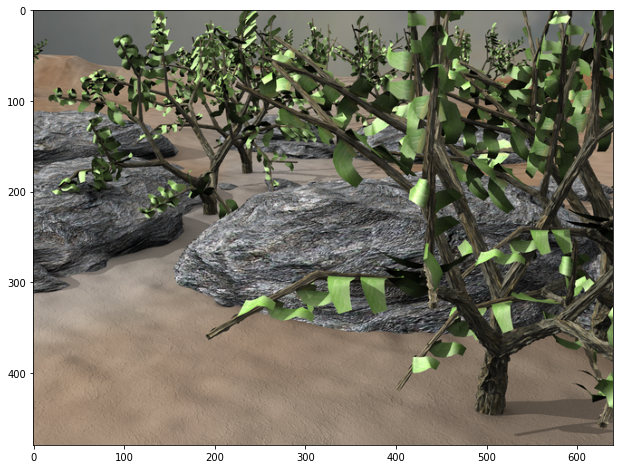

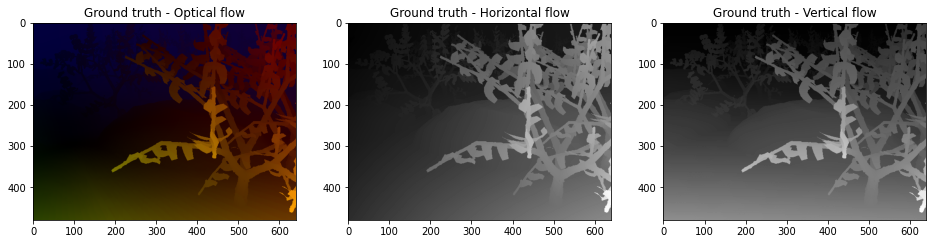


Small window size (3)
Average End Point Error =  3.468483168178341
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ideal window size (5)
Average End Point Error =  3.5060757092656636
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Weighted Gaussian kernel - window size (5)
Average End Point Error =  3.597327627306695
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


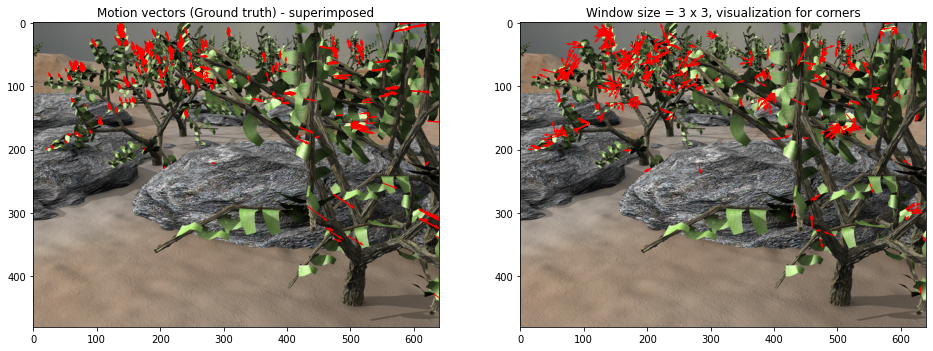

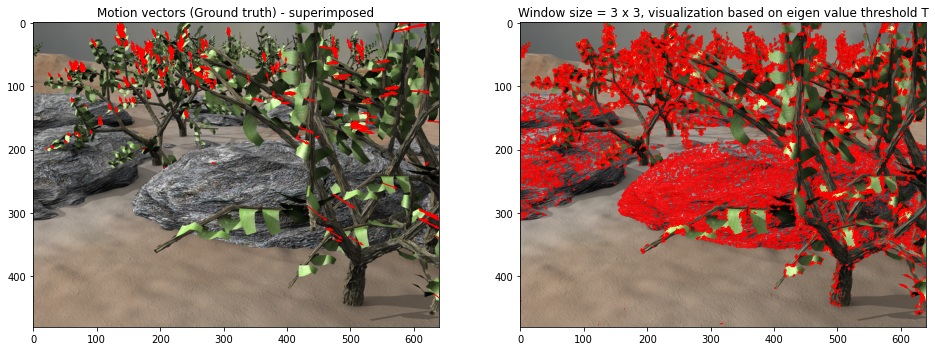

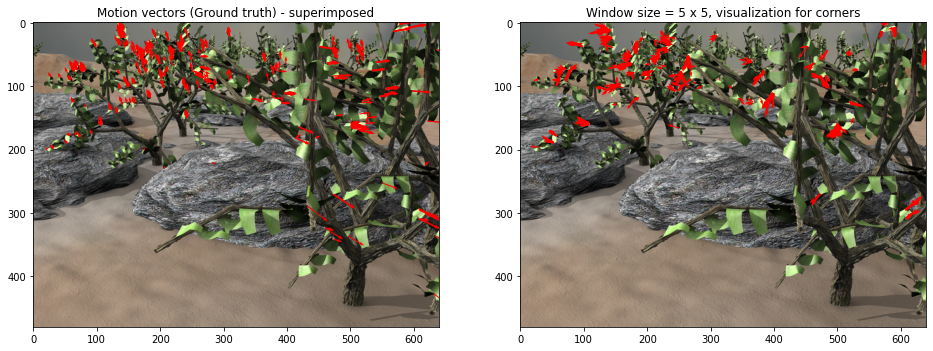

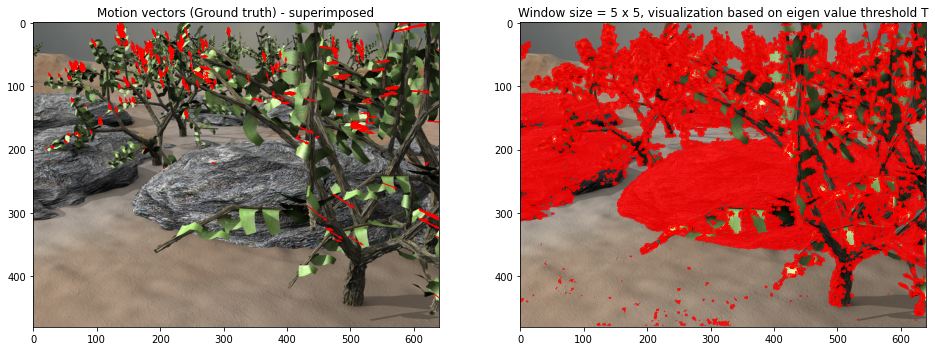

In [26]:
view_all_details(0)



RubberWhale




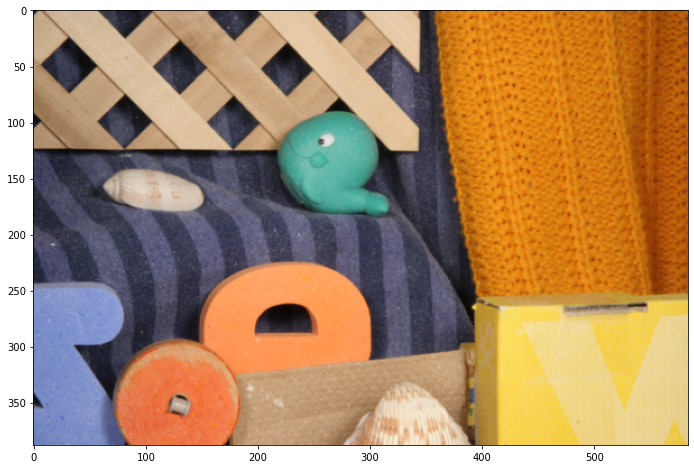

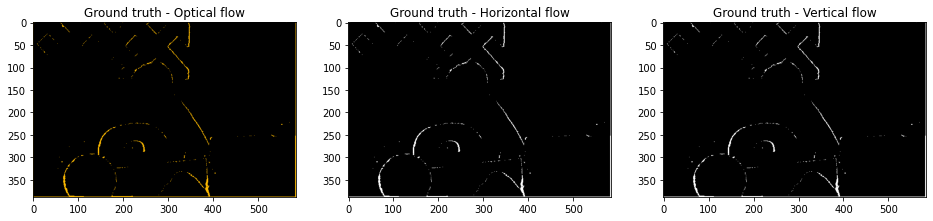


Small window size (3)
Average End Point Error =  157134849.72830588
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ideal window size (5)
Average End Point Error =  195537760.95321745
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Weighted Gaussian kernel - window size (5)
Average End Point Error =  195537760.9615397
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


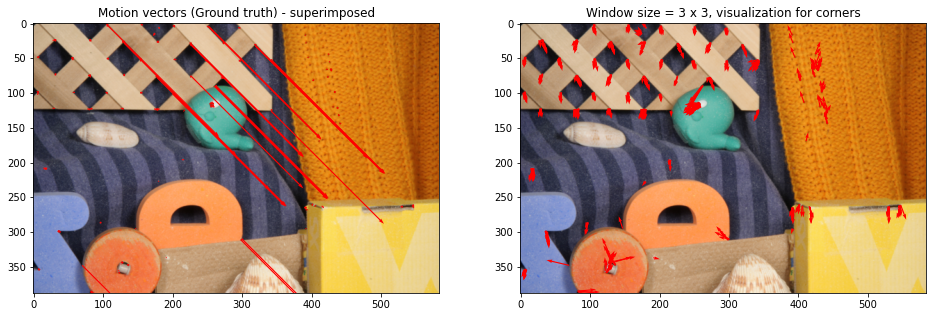

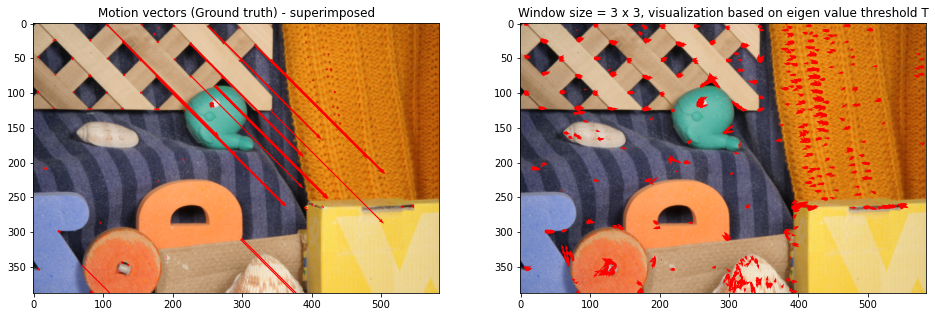

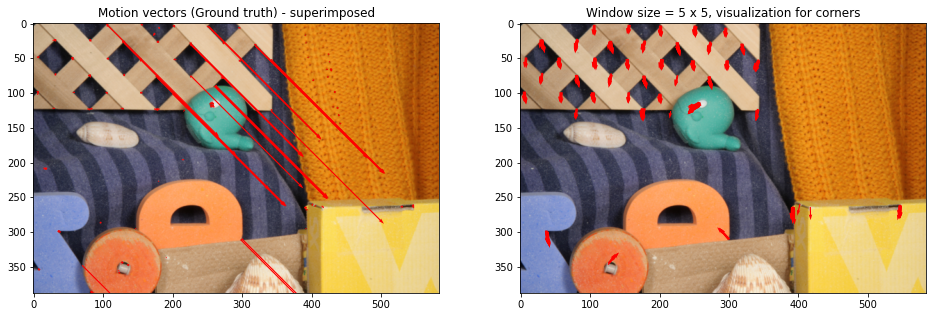

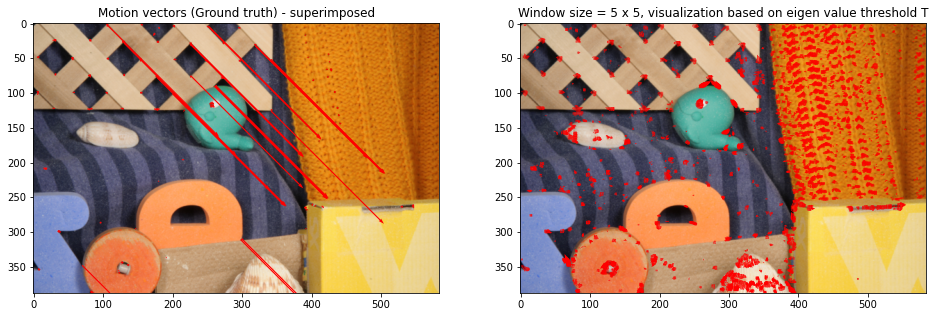

In [27]:
view_all_details(1)



Urban2




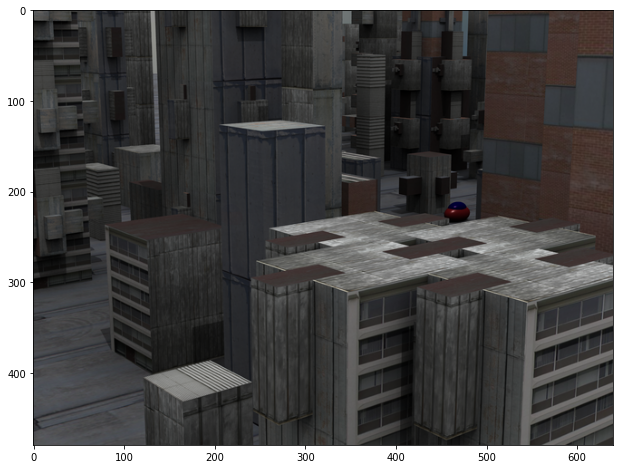

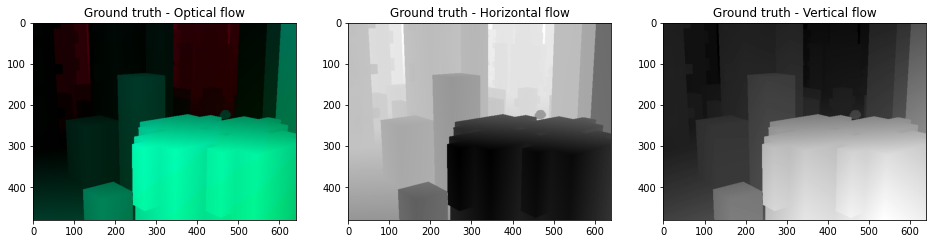


Small window size (3)
Average End Point Error =  12.715699557147408
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ideal window size (5)
Average End Point Error =  11.701275658465363
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Weighted Gaussian kernel - window size (5)
Average End Point Error =  11.724608224389788
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


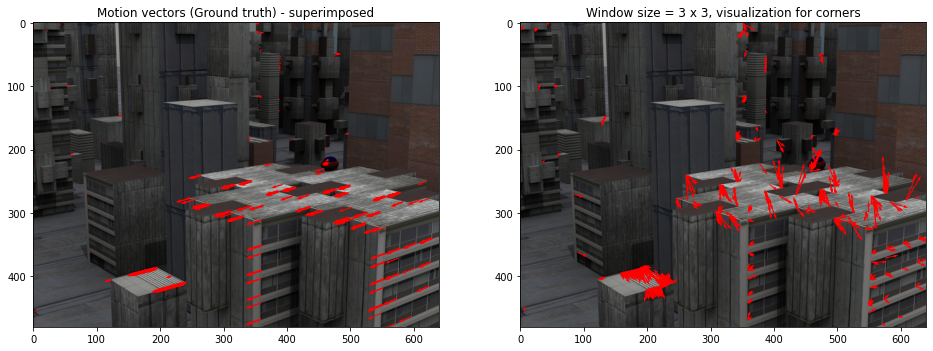

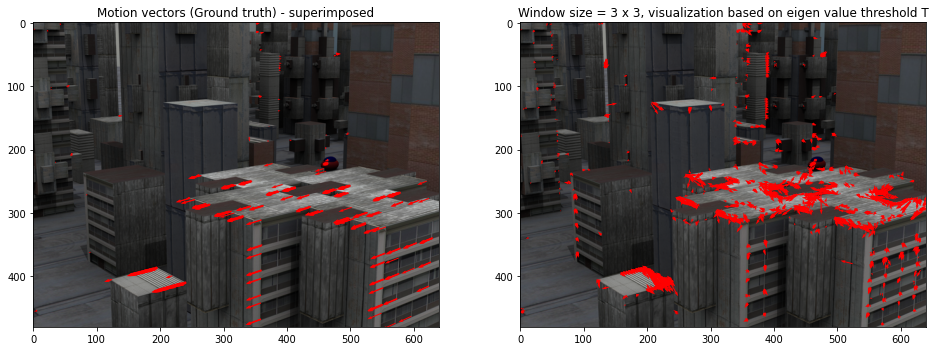

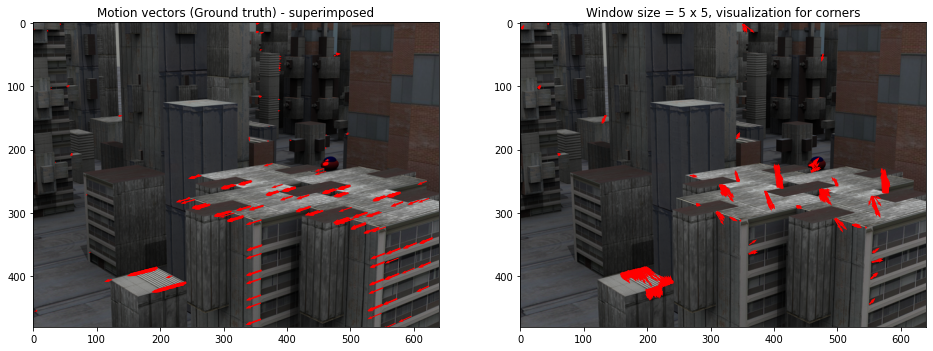

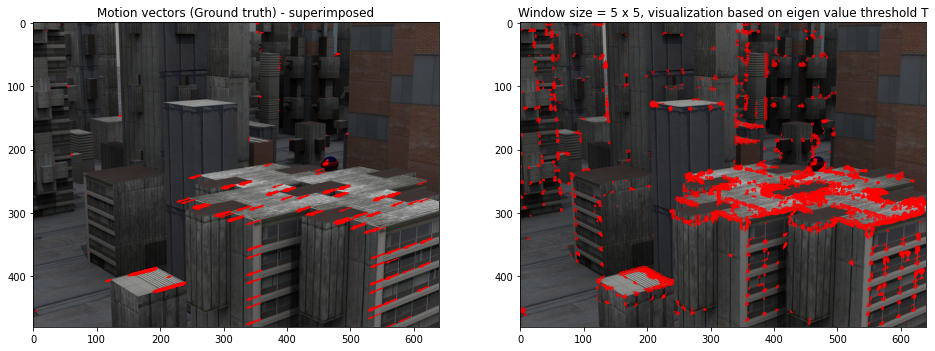

In [28]:
view_all_details(2)

****Analysis****

***Error analysis***

In all the cases, we can observe that the non-weighted version performs a tad bit better than the weighted version (where a Gaussian kernel is used for convolution in the intensity matrix). This highlights the importance of the spatial coherence assumption in computation of optical flow.

Further, there is an improvement in performance on increasing the window size, which indicates the susceptibility of noise of smaller window sizes (as sufficient spatial features are not effectively captured in a small window size where slight changes in surrounding pixels could lead to a pixel being considered a corner).

***Visualization***

We can observe that the output observed in cases where a threshold is defined is less cluttered than in the cases where the motion vectors of corners are visualized. This describes how defining a threshold highlights pixels which are least affected by noise and/or correspond to key points in the image.

***Moderate window size***

Clearly, the performance has improved by choosing a slightly larger window size, as it the motion vectors are now less prone to noise in the intensity data of the window.

***Large window size***

This cluttered-output due to large window size highlights how the motion vector computation (in this case) is less reliable, due to a very large neighbourhood being considered for every pixel to determine its corresponding motion vector. This creates a large set of constraints, thereby increasing the error and reducing the accuracy of the motion vector estimate. 

In [29]:
!zip -r Grove3.zip Grove3
!zip -r RubberWhale.zip RubberWhale
!zip -r Urban2.zip Urban2

  adding: Grove3/ (stored 0%)
  adding: Grove3/.ipynb_checkpoints/ (stored 0%)
  adding: Grove3/output/ (stored 0%)
  adding: Grove3/output/Grove3_5_None.png (deflated 2%)
  adding: Grove3/output/Grove3_3_None.png (deflated 1%)
  adding: Grove3/output/Grove3_5_0.01.png (deflated 1%)
  adding: Grove3/output/Grove3_3_0.01.png (deflated 1%)
  adding: Grove3/gt_flows.png (deflated 4%)
  adding: RubberWhale/ (stored 0%)
  adding: RubberWhale/.ipynb_checkpoints/ (stored 0%)
  adding: RubberWhale/output/ (stored 0%)
  adding: RubberWhale/output/RubberWhale_3_0.01.png (deflated 1%)
  adding: RubberWhale/output/RubberWhale_5_None.png (deflated 1%)
  adding: RubberWhale/output/RubberWhale_3_None.png (deflated 1%)
  adding: RubberWhale/output/RubberWhale_5_0.01.png (deflated 1%)
  adding: RubberWhale/gt_flows.png (deflated 15%)
  adding: Urban2/ (stored 0%)
  adding: Urban2/.ipynb_checkpoints/ (stored 0%)
  adding: Urban2/output/ (stored 0%)
  adding: Urban2/output/Urban2_3_0.01.png (deflated 2%)

In [30]:
from google.colab import files
files.download("Grove3.zip")
files.download("RubberWhale.zip")
files.download("Urban2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>